In [1]:
# %pip install showast@git+https://github.com/tzaffi/show_ast@unparse-source --upgrade

from showast import Settings, Renderers, show_text, show_ast, show_source, showast

Settings.update(dict(
    # Styling options:
    scale=1,
    font='courier',
    shape='none',
    terminal_color='#008040',
    nonterminal_color='#004080',

    # AST display options:
    omit_module=True,
    omit_docstrings=True,

    # By default omit_location_info and omit_source are True
    omit_location_info=False,
    locations_format="L{begin[0]}:{begin[1]}-L{end[0]}:{end[1]}",
    omit_source=False,

    # Rendering engine is expected to expose "render" function
    renderer=Renderers.graphviz,
))

In [2]:
# from dis import show_code
# from dataclasses import dataclass
# import dis

import pyteal as pt
from pyteal.compiler import source_map as ptsm

import ast
# from collections import OrderedDict
import json
import itertools
import inspect
import graphviz
from pprint import pprint
from tabulate import tabulate
from typing import Any, Iterable

In [3]:
hello = pt.Seq(pt.Log(pt.Concat(pt.Bytes("hello"),
    pt.Bytes("world"))), 
    pt.Int(1),
)

In [4]:
goodbye = pt.Return(pt.Int(42))

## EDGE CASE PROBLEM - Will not map operator in PyTeal code to TEAL when operator on its own line

This seems to be a systemic issue with `inspect.stack()` and frames. For example, consider the following cell and try to debug it.

You _CANNOT EVEN SET BREAKPOINTS_ at the `+` operators.

In [5]:
x = 42
y = (
    pt.Int(
        1
    ) 
    + 
    pt.Int(
        2
    ) 
    + 
    pt.Int(
        3
    ) 
    + 
    pt.Int(
        4
    ) 
    + 
    pt.Int(
        5
    )
    + 
    pt.Int(
        x
    )
)

In [6]:
from pyteal.compiler.source_map_imports_test import goodnum, double_exp, cat
from pyteal.types import TealType

x = pt.ScratchVar(TealType.uint64)

pure = pt.Seq(
    pt.Pop(hello), 
    pt.Pop(goodnum),
    x.store(pt.Int(1000)),
    pt.Pop(pt.Int(1337) - pt.Int(42)),
    goodbye,
)

In [7]:
simple_add = pt.Int(1) + pt.Int(2) + pt.Int(3) + pt.Int(4) + pt.Int(5)

In [8]:
line_sep_add = (pt.Int(1) 
    +
    pt.Int(2)
     +
    pt.Int(3)
     +
    pt.Int(4)
     +
    pt.Int(5)
)

In [9]:
line_sep_pt_add = pt.Add(
    pt.Add(
        pt.Add(
            pt.Add(
                pt.Int(1),
                pt.Int(2),
            ),
            pt.Int(3),
        ),
        pt.Int(4),
    ),
    pt.Int(5),
)

In [11]:
some_subroutines = pt.Seq(
    pt.Log(cat(pt.Bytes("Mapping "), pt.Bytes("PyTeal"))),
    pt.Log(pt.Bytes("this compiles but it'll blow up when executed")),
    double_exp(),
)

In [12]:
very_long = (pt.Int(1) + pt.Int(2) + pt.Int(3) + pt.Int(4) + pt.Int(5) + pt.Int(6) + pt.Int(7) + pt.Int(8) + pt.Int(9) + pt.Int(10) + pt.Int(11) + pt.Int(12) + pt.Int(13) 
    + pt.Int(14) + pt.Int(15) + pt.Int(16) + pt.Int(17) + pt.Int(18))

In [13]:
from pyteal.types import TealType

x3 = pt.ScratchVar(TealType.uint64); semi_coloned = pt.Seq(pt.Pop(hello), pt.Pop(goodnum),x3.store(pt.Int(1000)),pt.Pop(pt.Int(1337) - pt.Int(42)),goodbye)

In [14]:
program = {
    "pure": pure,
    "simple add": simple_add,
    "line sep add": line_sep_add,
    "line sep pt.Add": line_sep_pt_add,
    "some subroutines":  some_subroutines,
    "very long":  very_long,
    "semi-coloned": semi_coloned,
}

In [15]:
c = itertools.count()

def next_idx():
    return 6 + next(c)

source = {
    "pure": _ih[next_idx()],
    "simple add": _ih[next_idx()],
    "line sep add": _ih[next_idx()],
    "line sep pt.Add": _ih[next_idx()],
    "some subroutines":  _ih[next_idx()],
    "very long": _ih[next_idx()],
    "semi-coloned": _ih[next_idx()],
}

In [16]:
program.keys()

dict_keys(['pure', 'simple add', 'line sep add', 'line sep pt.Add', 'some subroutines', 'very long', 'semi-coloned'])

In [17]:
_TL = "TL"
_Teal = "Teal"
_PTE = "PTE"
_PTQ = "PTQ"
_PTC = "PTC"
_PTCW = "PTCW"
_PT_path = "PT path"
_PTL = "PTL"
_PTCC = "PTCC"
_PT_AST = "PT AST"
_PT_frame = "PT frame"

def run_example(program_key="some subroutines"):
    _, lines, components = pt.Compilation(program[program_key], pt.Mode.Application, version=7)
    m = ptsm.get_source_map(lines, components, add_extras=True)
    show_text(source[program_key])
    print(ptsm.tabulate_source_map(
        m,
        teal_line_col=_TL,
        teal_code_col=_Teal,
        pyteal_exec_col=_PTE,
        pyteal_code_window=_PTCW,
        pyteal_code_context_col=_PTCC,
        pyteal_path_col=_PT_path,
        pyteal_line_col=_PTL,
        pyteal_component_col=_PTC,
        pyteal_qualname_col=_PTQ,
        pyteal_ast_col=_PT_AST,
    ))
    return m

In [18]:
# class ASTCache:
#     frozen: bool = False

#     _sources: dict[string, string] = {}
#     _asts: dice[string, ]

def add_asts_to_frames(frames: Iterable[ptsm.PyTealFrame]):
    """And do it without compiling more than once per file"""
    def get_jupyter_index(code) -> int | None:
        indices = [i for i, cell_code in enumerate(_ih) if code in cell_code]
        return indices[0] if indices else None


    locations = [f.location() for f in frames]
    files = [f.file() for f in frames]
    codes = [f.code() for f in frames]
    jupyter_idx = [get_jupyter_index(c) for c in codes]
    # file2source = {f. for i, idx in enumerate(jupyter_idx) }
    # sources = [_ih[idx] if idx is not None else open(files[i]).read() for i, idx in enumerate(jupyter_idx)]

    file2source = {}
    file2ast = {}
    for i, f in enumerate(files):
        if f in file2source:
            continue

        idx = jupyter_idx[i]
        source = _ih[idx] if idx is not None else open(f).read()

        file2source[f] = source
        file2ast[f] = ast.parse(source)

    
    for i, f in enumerate(frames):
        idx = jupyter_idx[i]
        file = f.file()
        f.source = file2source[file]
        f.ast = file2ast[file]
    
    
    return file2source, file2ast

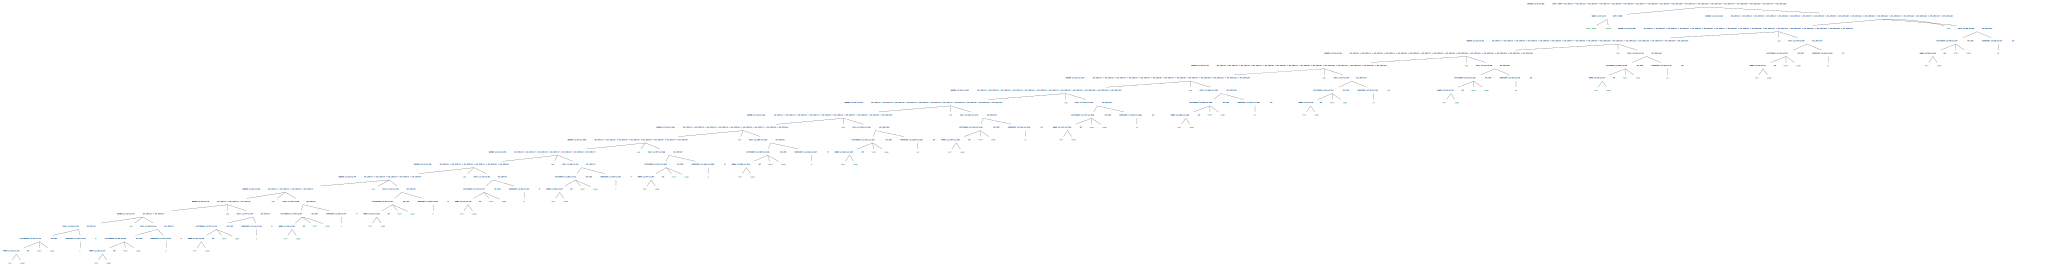

╒══════╤═══════════════════╤═════════════════════════════════════════════════════════╤═══════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════╤═══════╤═════════════════════════╤══════════════════════════════╤═══════════════════════════════════╕
│   TL │ Teal              │ PTE                                                     │ PTCW          │ PTCC                                                                                                                                                        │ PT path                                                                                      │   PTL │ PTC                     │ PTQ                          │ PT AST                            │
╞══════╪═══════════════════╪═════════════════════════════════════════════════════════╪

In [19]:
m = run_example("semi-coloned")

In [20]:
frames = [smi.frame for smi in m.values()]

f2s, f2ast = add_asts_to_frames(frames)

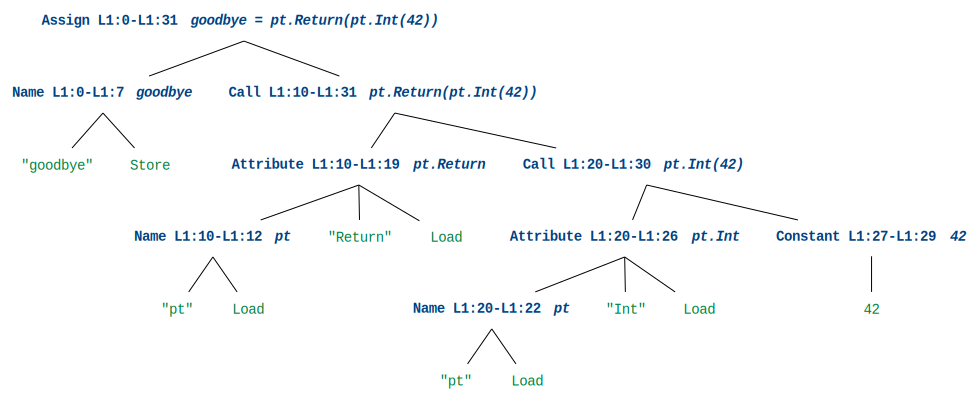

In [21]:
f2ast.keys()

show_ast(list(f2ast.values())[-1])

In [22]:
import ast
from pprint import pprint

class CallVisitor(ast.NodeVisitor):
    def print(self, node):
        nl = "_" * 10 + "\n"
        print(f"{nl}Node{type(node)} [{node.lineno}:{node.col_offset}-->{node.end_lineno}:{node.end_col_offset}]")
        for f in node._fields:
            print(f"{f}={getattr(node, f)}")
        

    def visit_Call(self, node):
        self.print(node)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_Name(self,node):
        self.print(node)
        # print('Node type: Name\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_Constant(self,node):
        self.print(node)
        # print('Node type: Constant\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_keyword(self,node):
        self.print(node)
        # print('Node type: keyword\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)



visitor = CallVisitor()
tree = ast.parse("myfunc(a, 100, found=True)", mode='eval')
pprint(ast.dump(tree))
visitor.visit(tree)

("Expression(body=Call(func=Name(id='myfunc', ctx=Load()), args=[Name(id='a', "
 "ctx=Load()), Constant(value=100)], keywords=[keyword(arg='found', "
 'value=Constant(value=True))]))')
__________
Node<class 'ast.Call'> [1:0-->1:26]
func=<ast.Name object at 0x10e6ef370>
args=[<ast.Name object at 0x10e6ef340>, <ast.Constant object at 0x10e6ef3d0>]
keywords=[<ast.keyword object at 0x10e6ef400>]
__________
Node<class 'ast.Name'> [1:0-->1:6]
id=myfunc
ctx=<ast.Load object at 0x104ab03d0>
__________
Node<class 'ast.Name'> [1:7-->1:8]
id=a
ctx=<ast.Load object at 0x104ab03d0>
__________
Node<class 'ast.Constant'> [1:10-->1:13]
value=100
kind=None
__________
Node<class 'ast.keyword'> [1:15-->1:25]
arg=found
value=<ast.Constant object at 0x10e6ef430>
__________
Node<class 'ast.Constant'> [1:21-->1:25]
value=True
kind=None


In [23]:
visitor.visit(frames[1].ast)

__________
Node<class 'ast.Name'> [1:0-->1:5]
id=hello
ctx=<ast.Store object at 0x104ab0430>
__________
Node<class 'ast.Call'> [1:8-->4:1]
func=<ast.Attribute object at 0x10e6a7d60>
args=[<ast.Call object at 0x10e6a7d00>, <ast.Call object at 0x10e6a79a0>]
keywords=[]
__________
Node<class 'ast.Name'> [1:8-->1:10]
id=pt
ctx=<ast.Load object at 0x104ab03d0>
__________
Node<class 'ast.Call'> [1:15-->2:23]
func=<ast.Attribute object at 0x10e6a7cd0>
args=[<ast.Call object at 0x10e6a7c70>]
keywords=[]
__________
Node<class 'ast.Name'> [1:15-->1:17]
id=pt
ctx=<ast.Load object at 0x104ab03d0>
__________
Node<class 'ast.Call'> [1:22-->2:22]
func=<ast.Attribute object at 0x10e6a7c40>
args=[<ast.Call object at 0x10e6a7be0>, <ast.Call object at 0x10e6a7a60>]
keywords=[]
__________
Node<class 'ast.Name'> [1:22-->1:24]
id=pt
ctx=<ast.Load object at 0x104ab03d0>
__________
Node<class 'ast.Call'> [1:32-->1:49]
func=<ast.Attribute object at 0x10e6a7bb0>
args=[<ast.Constant object at 0x10e6a7b50>]
keywo

In [24]:
print(ast.dump(frames[1].ast, include_attributes=True, indent="  "))

Module(
  body=[
    Assign(
      targets=[
        Name(
          id='hello',
          ctx=Store(),
          lineno=1,
          col_offset=0,
          end_lineno=1,
          end_col_offset=5)],
      value=Call(
        func=Attribute(
          value=Name(
            id='pt',
            ctx=Load(),
            lineno=1,
            col_offset=8,
            end_lineno=1,
            end_col_offset=10),
          attr='Seq',
          ctx=Load(),
          lineno=1,
          col_offset=8,
          end_lineno=1,
          end_col_offset=14),
        args=[
          Call(
            func=Attribute(
              value=Name(
                id='pt',
                ctx=Load(),
                lineno=1,
                col_offset=15,
                end_lineno=1,
                end_col_offset=17),
              attr='Log',
              ctx=Load(),
              lineno=1,
              col_offset=15,
              end_lineno=1,
              end_col_offset=21),
            a

In [25]:
idx = 8
m[idx].line, m[idx].teal, m[idx].frame.lineno(), m[idx].frame.code()

(8, 'int 42', 4, 'goodnum = pt.Int(42)')

In [26]:
pt_frame = m[idx].frame
tb_frame = pt_frame.frame.frame

In [27]:
# %pip install executing
import executing

print(executing.Source.executing(tb_frame).node)


None


In [28]:
executing.Source.executing(tb_frame).text()

''

In [29]:
executing.Source.executing(tb_frame).code_qualname()

'<module>'